# Identifying Spike Time Oscillations in Rat Motor Cortex

This notebook demonstrates how to reproduce the essential elements of Fig. 6 in:

> [**Discovering precise temporal patterns in large-scale neural recordings through robust and interpretable time warping**](https://doi.org/10.1016/j.neuron.2019.10.020). Williams AH, Poole B, Maheswaranathan N, Dhawale AK, Fisher T, Wilson CD, Brann DH, Trautmann E, Ryu S, Shusterman R, Rinberg D, Ölveczky BP, Shenoy KV, Ganguli S (2020). *Neuron*. 105(2):246-259.e8

These data were collected by Ashesh Dhawale in Bence Ölveczky's lab. Further questions regarding these data should be directed to dhawale@fas.harvard.edu and olveczky@fas.harvard.edu

#### Import libraries and load data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from affinewarp import SpikeData

D = dict(np.load("motor_ctx_data.npz"))

tmin = D["tmin"][0]
tmax = D["tmax"][0]
tap1 = D["tap1"]
tap2 = D["tap2"]
ipi = tap2 - tap1

data = SpikeData(
    trials=D["trial_ids"],
    spiketimes=D["spiketimes"],
    neurons=D["neuron_ids"],
    tmin=D["tmin"][0],
    tmax=D["tmax"][0],
)

#### Model hyperparameters

In [3]:
BINSIZE = 10.0   # ms
NBINS = int((data.tmax - data.tmin) / BINSIZE)
MAXLAG = 0.1

#### Bin spikes

The binned spike counts here can be normalized (e.g. z-scoring) and this does not qualitatively change the result.

In [4]:
binned = data.bin_spikes(NBINS)

# # Uncomment to z-score...
# binned -= binned.mean(axis=(1, 2), keepdims=True)
# binned /= binned.std(axis=(1, 2), keepdims=True)

#### Fit model

Loss: 0.07: 100%|██████████| 50/50 [00:07<00:00,  6.41it/s]


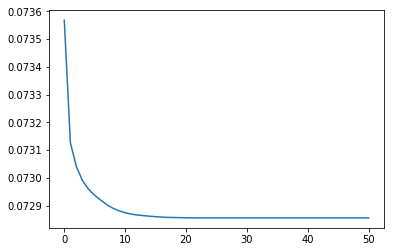

In [5]:
from affinewarp import ShiftWarping
from affinewarp.crossval import heldout_transform

# Create model.
model = ShiftWarping(maxlag=MAXLAG)

# Validated spike raster transforms
aligned_data = heldout_transform(model, binned, data);

# Fit model to all neurons (for aligning behavior).
model.fit(binned, iterations=50)
plt.plot(model.loss_hist)

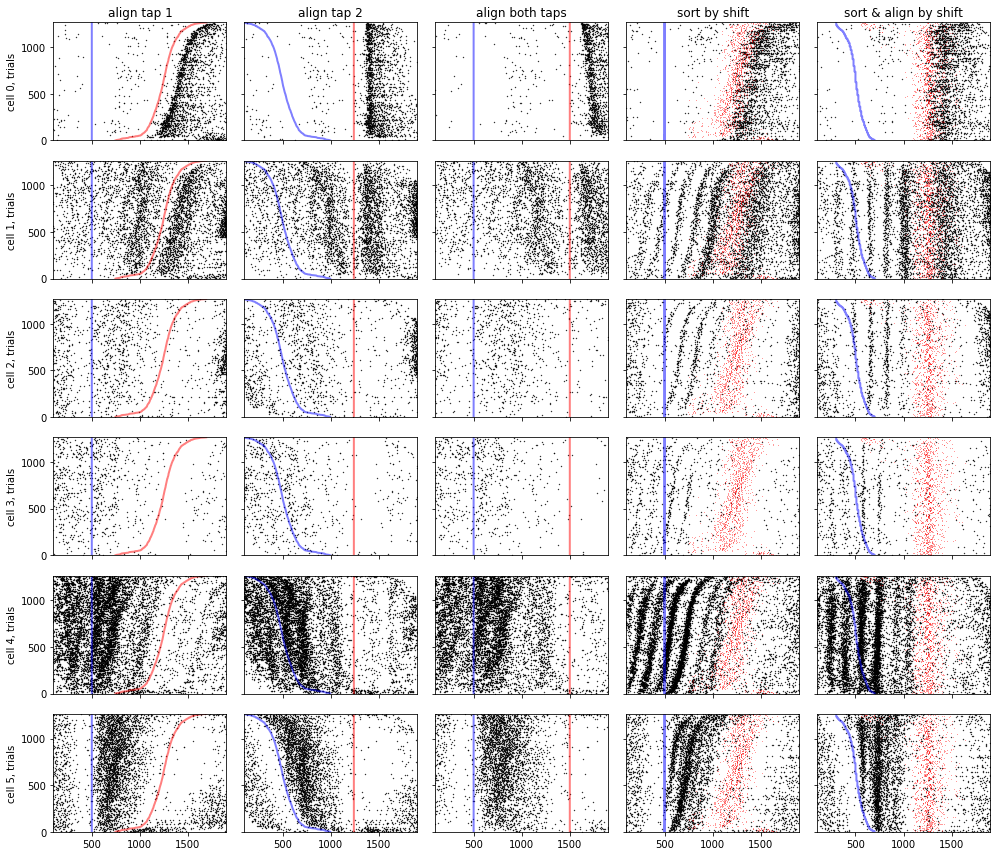

In [6]:
# Create manual warping, aligning to second lever press.
from affinewarp import PiecewiseWarping
t0 = np.column_stack((tap2 / tmax, np.full(tap2.size, .75)))
align_tap2 = PiecewiseWarping(n_knots=0)
align_tap2.manual_fit(binned, t0, recenter=True)

# Create manual warping, aligning to both lever press.
align_both = PiecewiseWarping(n_knots=0)
t0 = np.tile((tap1 / tmax)[:, None], (1, 2))
t1 = np.column_stack((tap2 / tmax, np.full(ipi.size, .75)))
align_both.manual_fit(binned, t0, t1, recenter=False)
d = align_both.transform(data)

# Example neurons shown in the paper.
neuron_ids = [3, 13, 10, 28, 29, 25]

# Create figure
fig, axes = plt.subplots(6, 5, figsize=(14, 12), sharex=True, sharey=True)
scatter_kw = dict(s=2, c='k', lw=0, alpha=.8)
line_kw = dict(lw=2, alpha=.5)
trial_range = np.arange(len(binned))
    
# Plot unwarped data
for n, ax in zip(neuron_ids, axes[:, 0]):
    idx = data.neurons == n
    y, x = data.trials[idx], data.spiketimes[idx]
    ax.scatter(x, y, **scatter_kw)
    ax.plot(tap2, np.arange(tap2.size), '-r', lw=2, alpha=.5)
    ax.plot(tap1, np.arange(ipi.size), '-b', lw=2, alpha=.5)

# Plot data aligned to tap2
tap2_data = align_tap2.transform(data)

for n, ax in zip(neuron_ids, axes[:, 1]):
    idx = tap2_data.neurons == n
    y, x = tap2_data.trials[idx], tap2_data.spiketimes[idx]
    ax.scatter(x, y, **scatter_kw)
    t2 = align_tap2.event_transform(trial_range, tap2 / tmax) * tmax
    ax.plot(t2, trial_range, '-r', **line_kw)
    t1 = align_tap2.event_transform(trial_range, tap1 / tmax) * tmax
    ax.plot(t1, trial_range, '-b', **line_kw)

# Plot data aligned to both lever presses
for n, ax in zip(neuron_ids, axes[:, 2]):
    _d = d.select_neurons(n)
    y, x = _d.trials, _d.spiketimes
    ax.scatter(x, y, **scatter_kw)
    t2 = align_both.event_transform(trial_range, tap2 / tmax) * tmax
    ax.plot(t2, trial_range, '-r', **line_kw)
    t1 = align_both.event_transform(trial_range, tap1 / tmax) * tmax
    ax.plot(t1, trial_range, '-b', **line_kw)

# Plot data with trials sorted by shift model.
kk = model.argsort_warps()
sorted_data = data.reorder_trials(kk)

for n, ax in zip(neuron_ids, axes[:,3]):
    idx = sorted_data.neurons == n
    y, x = sorted_data.trials[idx], sorted_data.spiketimes[idx]
    ax.scatter(x, y, **scatter_kw)
    ax.plot(tap1, trial_range[kk], '-b', **line_kw)
    ax.scatter(tap2, trial_range[kk], c='r', s=1, alpha=.5, lw=0)

# Plot data with sorted and aligned by shift model.
sorted_aligned_data = aligned_data.reorder_trials(kk)

for n, ax in zip(neuron_ids, axes[:,4]):
    idx = sorted_aligned_data.neurons == n
    y, x = sorted_aligned_data.trials[idx], sorted_aligned_data.spiketimes[idx]
    ax.scatter(x, y, **scatter_kw)
    y = np.arange(tap2.size)
    ax.plot(
        model.event_transform(trial_range[kk], tap1 / tmax) * tmax,
        trial_range, "-b", **line_kw)
    ax.scatter(
        model.event_transform(trial_range[kk], tap2 / tmax) * tmax,
        trial_range, c='r', s=1, alpha=.5, lw=0)

# Format axes.
for ax in axes.ravel():
    ax.set_xlim(100, 1900)
    ax.set_ylim(0, data.n_trials)

axes[0, 0].set_title("align tap 1")
axes[0, 1].set_title("align tap 2")
axes[0, 2].set_title("align both taps")
axes[0, 3].set_title("sort by shift")
axes[0, 4].set_title("sort & align by shift")

for s, ax in enumerate(axes[:, 0]):
    ax.set_ylabel("cell {}, trials".format(s))

fig.tight_layout()

#### Does linear warping reveal additional structure?

These spike time oscillations are also identified by a linear warping model, as shown below.

Loss improvement: 2.18%: 100%|██████████| 50/50 [01:28<00:00,  1.71s/it]


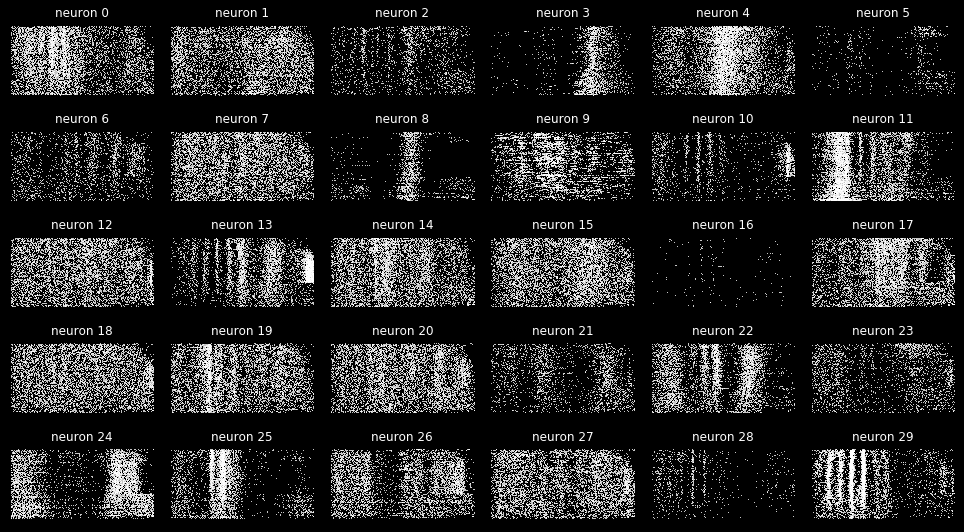

In [7]:
from affinewarp.visualization import rasters

lin_model = PiecewiseWarping() # Note, can add smoothness regularization here, if desired.
lin_model.fit(binned)
lin_aligned_data = lin_model.transform(data)

rasters(lin_aligned_data);

For comparison, shift-only warping produces the following rasters:

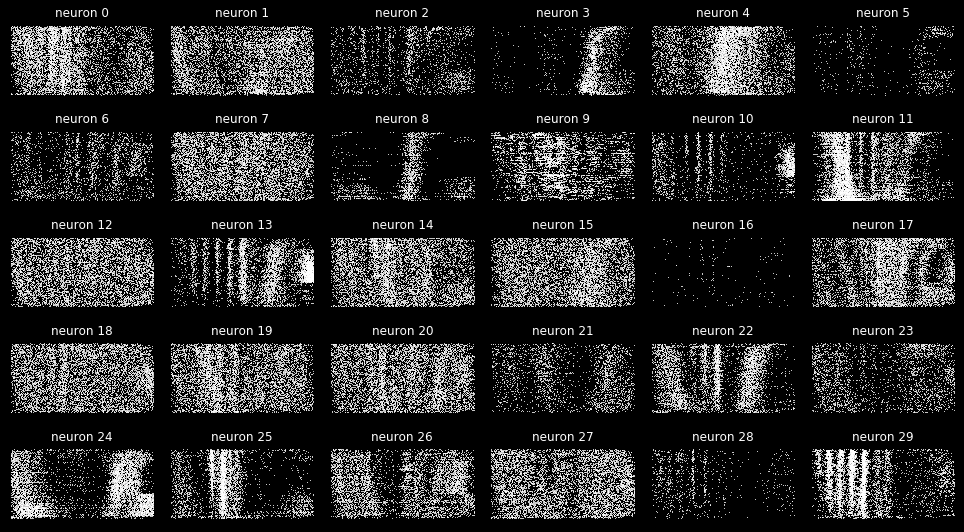

In [8]:
rasters(aligned_data);

And the raw data:

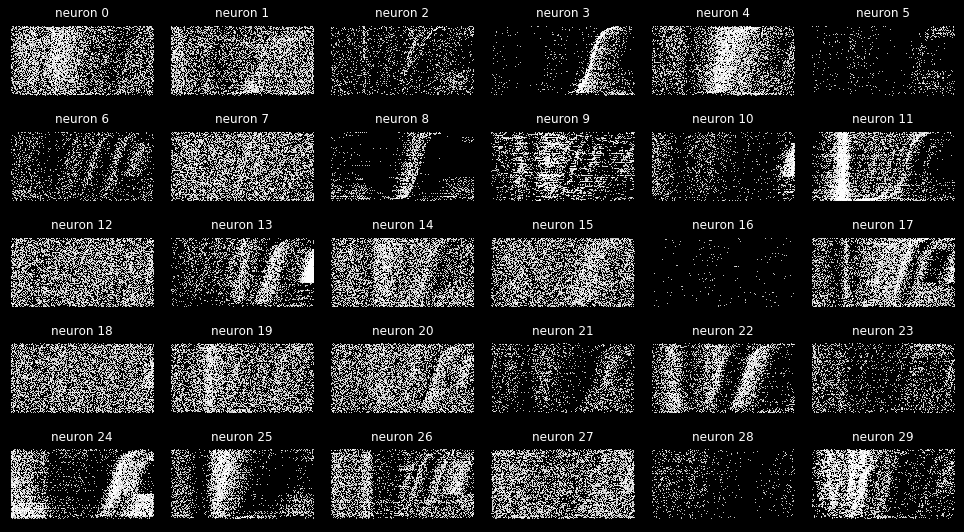

In [9]:
rasters(data);